<a href="https://colab.research.google.com/github/Kirti-Pant/ConvNeXT-Base-for-Brain-Tumor-Classification/blob/main/ConvNeXT_model_and_other_models_Training_and_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BASIC INSTALLMENTS OF LIBRARIES

In [ ]:
!pip install tensorflow;
!pip install keras;
!pip install opencv-python;
!pip install matplotlib;
!pip install pandas;
!pip install numpy;
!pip install scikit-learn;
!pip install seaborn;
!pip install matplotlib;
!pip install pandas;
!pip install numpy;
!pip install scikit-learn;
!pip install seaborn;
!pip install torch torchvision
!pip install timm
!pip install scikit-image pillow
!pip install torchio
!pip install albumentations
!pip install segmentation-models
!pip install optuna hyperopt
!pip install shap lime
!pip install easyocr




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=dd327197f6889775abeacb128fd3536b0f23b606b146eca67b5d42624ad20907
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#DATA LOADING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copied pituitary to /content/dataset/pituitary
Copied meningioma to /content/dataset/meningioma
Copied glioma to /content/dataset/glioma
Copied notumor to /content/dataset/notumor


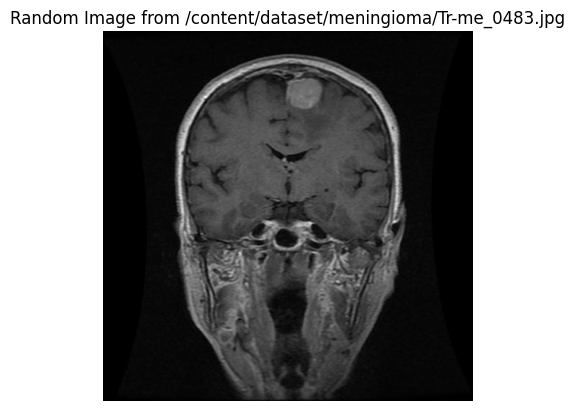

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

data_folder = '/content/drive/MyDrive/newd/Training'
dataset_path = '/content/dataset'


if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

subfolders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]
for folder in subfolders:
    source_folder = os.path.join(data_folder, folder)
    destination_folder = os.path.join(dataset_path, folder)

    if not os.path.exists(destination_folder):
        shutil.copytree(source_folder, destination_folder)
    else:
        print(f"Folder {folder} already exists in {dataset_path}. Skipping.")
    print(f"Copied {folder} to {destination_folder}")


all_image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

if all_image_paths:
    random_image_path = random.choice(all_image_paths)
    img = mpimg.imread(random_image_path)
    plt.imshow(img)
    plt.title(f"Random Image from {random_image_path}")
    plt.axis('off')
    plt.show()
else:
    print("No images found in the dataset.")

# Using Albumentations

In [ ]:
import albumentations as A
import tensorflow as tf
import cv2
import numpy as np

transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
])

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.numpy_function(func=apply_albumentations, inp=[image], Tout=tf.float32)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_albumentations(image):
    img = image.numpy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    augmented = transform(image=img)
    aug_img = augmented['image']
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
    aug_img = aug_img / 255.0
    return aug_img.astype(np.float32)


/tmp/ipython-input-2933686316.py:12: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


# Dataset Training Splitting 80% Training and 20% Validation

In [ ]:
import os
import albumentations as A
import tensorflow as tf
import cv2
import numpy as np

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
])

val_transform = A.Compose([
    A.Resize(224, 224),
])

def apply_albumentations(image, transform):
    img = image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    augmented = transform(image=img)
    aug_img = augmented['image']
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
    aug_img = aug_img / 255.0
    return aug_img.astype(np.float32)

def preprocess_image_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.numpy_function(func=lambda x: apply_albumentations(x, train_transform), inp=[image], Tout=tf.float32)
    image.set_shape([224, 224, 3])
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def preprocess_image_val(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.numpy_function(func=lambda x: apply_albumentations(x, val_transform), inp=[image], Tout=tf.float32)
    image.set_shape([224, 224, 3])
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def get_image_paths_and_labels(folder_path):
    class_names = sorted(os.listdir(folder_path))
    image_paths = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            for img_name in os.listdir(class_folder):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_folder, img_name))
                    labels.append(label)
    return image_paths, labels


train_folder = '/content/dataset_split/train'
val_folder = '/content/dataset_split/val'


train_paths, train_labels = get_image_paths_and_labels(train_folder)
val_paths, val_labels = get_image_paths_and_labels(val_folder)


train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image_train).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image_val).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Train dataset size: {len(train_paths)} images")
print(f"Validation dataset size: {len(val_paths)} images")


Train dataset size: 4568 images
Validation dataset size: 1144 images


In [ ]:
def preprocess_image_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.numpy_function(func=lambda x: apply_albumentations(x, train_transform), inp=[image], Tout=tf.float32)
    image.set_shape([224, 224, 3])
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def preprocess_image_val(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.numpy_function(func=lambda x: apply_albumentations(x, val_transform), inp=[image], Tout=tf.float32)
    image.set_shape([224, 224, 3])
    image = tf.clip_by_value(image, 0, 1)
    return image, label


# MobileNetV3Large

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


num_classes = 4


model = models.mobilenet_v3_large(pretrained=True)


if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(in_features, num_classes)
else:
    raise ValueError("Unexpected model classifier structure")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
outputs = model(dummy_input)
print(outputs)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 127MB/s]


tensor([[-0.0928,  0.0067, -0.0181,  0.1496]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20], Train Loss: 0.3609, Train Acc: 0.8811, Val Loss: 0.3444, Val Acc: 0.8584
Epoch [2/20], Train Loss: 0.0937, Train Acc: 0.9704, Val Loss: 0.4104, Val Acc: 0.8339
Epoch [3/20], Train Loss: 0.0443, Train Acc: 0.9866, Val Loss: 0.5426, Val Acc: 0.8287
Epoch [4/20], Train Loss: 0.0232, Train Acc: 0.9928, Val Loss: 0.2244, Val Acc: 0.9222
Epoch [5/20], Train Loss: 0.0149, Train Acc: 0.9947, Val Loss: 0.0528, Val Acc: 0.9825
Epoch [6/20], Train Loss: 0.0155, Train Acc: 0.9943, Val Loss: 0.0748, Val Acc: 0.9790
Epoch [7/20], Train Loss: 0.0179, Train Acc: 0.9943, Val Loss: 0.0757, Val Acc: 0.9755
Epoch [8/20], Train Loss: 0.0110, Train Acc: 0.9967, Val Loss: 0.0305, Val Acc: 0.9860
Epoch [9/20], Train Loss: 0.0028, Train Acc: 0.9993, Val Loss: 0.0251, Val Acc: 0.9895
Epoch [10/20], Train Loss: 0.0109, Train Acc: 0.9961, Val Loss: 0.0509, Val Acc: 0.9851
Epoch [11/20], Train Loss: 0.0040, Train Acc: 0.9989, Val Loss: 0.0468, Val Acc: 0.9860
Epoch [12/20], Train Loss: 0.0032, Train 

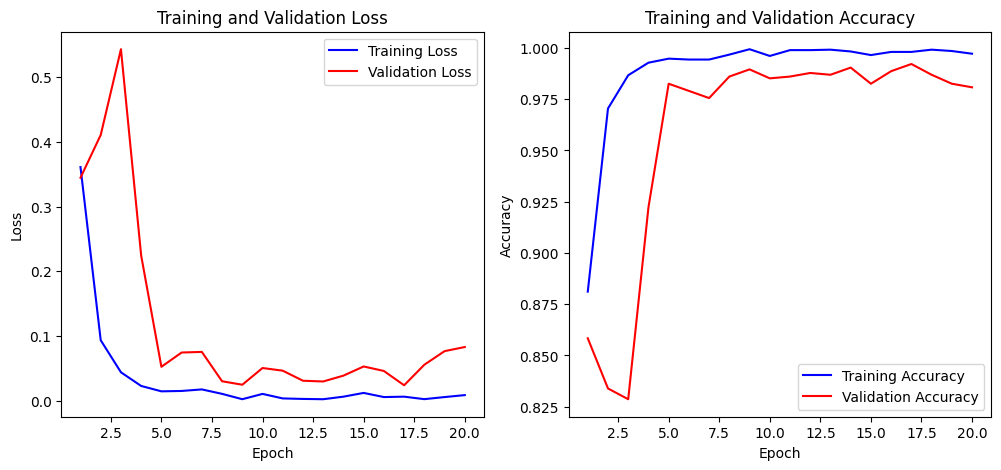

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3.classifier[3] = nn.Linear(mobilenet_v3.classifier[3].in_features, num_classes)
mobilenet_v3 = mobilenet_v3.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3.parameters(), lr=learning_rate)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    mobilenet_v3.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_v3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    mobilenet_v3.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet_v3(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(mobilenet_v3.state_dict(), 'mobilenetv3_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [ ]:
pip install nvidia-ml-py3


  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=b928d7cb28d9a054eb33229233ae4727a53661e2f961f3be6ff75a3c64b9126b
  Stored in directory: /root/.cache/pip/wheels/6e/65/79/33dee66cba26e8204801916dfee7481bccfd22905ebb841fe5
Successfully built nvidia-ml-py3


In [ ]:
import pynvml

def get_gpu_power_watt(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
    power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
    power_watt = power_mw / 1000.0
    pynvml.nvmlShutdown()
    return power_watt

if __name__ == "__main__":
    power = get_gpu_power_watt()
    print(f"GPU power consumption: {power:.2f} Watts")


GPU power consumption: 52.02 Watts


## Figshare Test Dataset(D2)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights


weights = MobileNet_V3_Large_Weights.DEFAULT
model = mobilenet_v3_large(weights=weights)


num_classes = 4
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 201MB/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn


class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ntest', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


num_classes = 4
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)


model.load_state_dict(torch.load('mobilenetv3_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor     0.9862    1.0000    0.9931       143
meningioma_tumor     1.0000    0.9803    0.9900       152
        no_tumor     1.0000    1.0000    1.0000       144
 pituitary_tumor     0.9935    1.0000    0.9967       152

        accuracy                         0.9949       591
       macro avg     0.9949    0.9951    0.9950       591
    weighted avg     0.9950    0.9949    0.9949       591



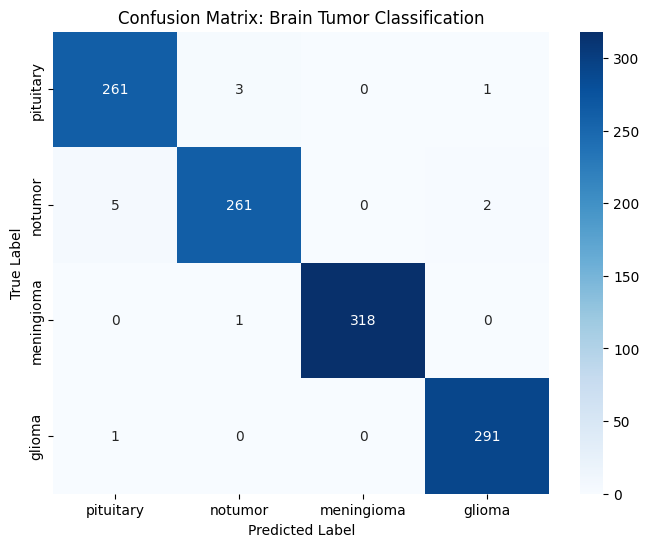

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataset:
        if images.dim() == 3:
            images = images.unsqueeze(0)

        images = images.to(device)
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        if labels.dim() == 0:
            y_true.append(labels.cpu().item())
            y_pred.append(predicted.cpu().item())
        else:
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)


class_names = ['pituitary', 'notumor', 'meningioma','glioma']


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Brain Tumor Classification')
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_probs = []

with torch.no_grad():
    for images, labels in val_dataset:
        if images.dim() == 3:
            images = images.unsqueeze(0)
        images = images.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)


        if isinstance(labels, torch.Tensor):
            if labels.dim() == 0:
                y_true.append(labels.cpu().item())
            else:
                y_true.extend(labels.cpu().numpy())
        else:
            y_true.append(labels)

        y_probs.extend(probs.cpu().numpy())


y_true = np.array(y_true)
y_probs = np.array(y_probs)


num_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

auc_score = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

print(f"Macro-Averaged AUC Score: {auc_score:.4f}")

Macro-Averaged AUC Score: 0.9997


In [ ]:
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataset:
        if images.dim() == 3:
            images = images.unsqueeze(0)
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)


        if isinstance(labels, torch.Tensor):
            if labels.dim() == 0:
                y_true.append(labels.cpu().item())
            else:
                y_true.extend(labels.cpu().numpy())
        else:
            y_true.append(labels)

        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

kappa_score = cohen_kappa_score(y_true, y_pred)
print(f"Cohen’s Kappa Score: {kappa_score:.4f}")

Cohen’s Kappa Score: 0.9848


## Kaggle Test Dataset(D3)

In [ ]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn


class_names = ['pituitary','meningioma','notumor','glioma']


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/newtest/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


num_classes = 4
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)


model.load_state_dict(torch.load('mobilenetv3_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9832    0.9767    0.9799       300
  meningioma     0.9701    0.9542    0.9621       306
     notumor     0.9854    0.9975    0.9914       405
      glioma     0.9901    0.9967    0.9934       300

    accuracy                         0.9825      1311
   macro avg     0.9822    0.9813    0.9817      1311
weighted avg     0.9824    0.9825    0.9824      1311



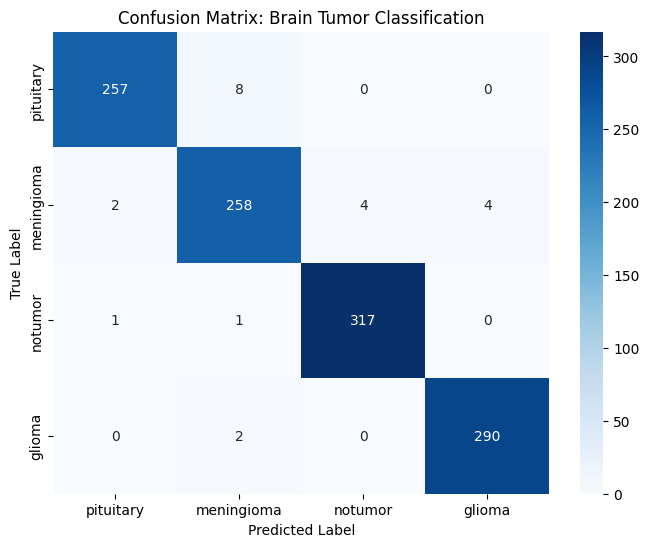

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataset:
        if images.dim() == 3:
            images = images.unsqueeze(0)

        images = images.to(device)
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        if labels.dim() == 0:
            y_true.append(labels.cpu().item())
            y_pred.append(predicted.cpu().item())
        else:
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())


y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)


class_names = ['pituitary','meningioma', 'notumor',  'glioma']


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Brain Tumor Classification')
plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_probs = []

with torch.no_grad():
    for images, labels in val_dataset:
        if images.dim() == 3:
            images = images.unsqueeze(0)
        images = images.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        if isinstance(labels, torch.Tensor):
            if labels.dim() == 0:  # scalar tensor
                y_true.append(labels.cpu().item())
            else:  # batched tensor
                y_true.extend(labels.cpu().numpy())
        else:
            y_true.append(labels)  # scalar int

        y_probs.extend(probs.cpu().numpy())


y_true = np.array(y_true)
y_probs = np.array(y_probs)

# Binarize the true labels for multi-class AUC calculation
num_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

# Compute macro-average AUC score
auc_score = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')

print(f"Macro-Averaged AUC Score: {auc_score:.4f}")


Macro-Averaged AUC Score: 0.9985


In [ ]:
import torch
import numpy as np
from sklearn.metrics import cohen_kappa_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataset:
        if images.dim() == 3:
            images = images.unsqueeze(0)
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)


        if isinstance(labels, torch.Tensor):
            if labels.dim() == 0:
                y_true.append(labels.cpu().item())
            else:
                y_true.extend(labels.cpu().numpy())
        else:
            y_true.append(labels)

        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

kappa_score = cohen_kappa_score(y_true, y_pred)
print(f"Cohen’s Kappa Score: {kappa_score:.4f}")


Cohen’s Kappa Score: 0.9743


## Other Dataset img size= 254X254 (D4)

In [ ]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn


class_names = ['glioma','meningioma','notumor','pituitary']


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/testcase/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


num_classes = 4
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)


model.load_state_dict(torch.load('mobilenetv3_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9877    0.9938    0.9908       324
  meningioma     0.9886    0.9803    0.9844       355
     notumor     0.9900    0.9950    0.9925       400
   pituitary     1.0000    0.9972    0.9986       351

    accuracy                         0.9916      1430
   macro avg     0.9916    0.9916    0.9916      1430
weighted avg     0.9916    0.9916    0.9916      1430



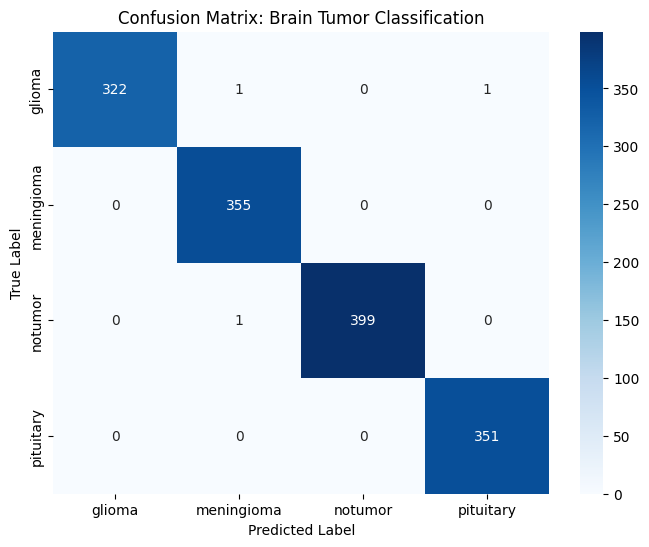

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)

class_names = ['glioma','meningioma','notumor','pituitary']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Brain Tumor Classification')
plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

y_true = []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)


        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_probs = np.array(y_probs)


num_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))


auc_score = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC Score: {auc_score:.4f}")

y_pred = np.argmax(y_probs, axis=1)
kappa_score = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")


Macro-Averaged AUC Score: 1.0000
Cohen's Kappa Score: 0.9972


# ResNet 152


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

num_classes = 4

model = models.resnet152(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
dummy_input = torch.randn(1, 3, 224, 224).to(device)
outputs = model(dummy_input)
print(outputs)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:07<00:00, 31.9MB/s]


tensor([[ 0.0634, -0.3519,  0.2320,  0.2247]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20], Train Loss: 0.2404, Train Acc: 0.9151, Val Loss: 0.0533, Val Acc: 0.9834
Epoch [2/20], Train Loss: 0.0650, Train Acc: 0.9796, Val Loss: 0.0424, Val Acc: 0.9895
Epoch [3/20], Train Loss: 0.0498, Train Acc: 0.9829, Val Loss: 0.0864, Val Acc: 0.9703
Epoch [4/20], Train Loss: 0.0232, Train Acc: 0.9934, Val Loss: 0.0548, Val Acc: 0.9860
Epoch [5/20], Train Loss: 0.0336, Train Acc: 0.9895, Val Loss: 0.0582, Val Acc: 0.9799
Epoch [6/20], Train Loss: 0.0129, Train Acc: 0.9965, Val Loss: 0.0913, Val Acc: 0.9755
Epoch [7/20], Train Loss: 0.0072, Train Acc: 0.9974, Val Loss: 0.0496, Val Acc: 0.9878
Epoch [8/20], Train Loss: 0.0404, Train Acc: 0.9851, Val Loss: 0.1300, Val Acc: 0.9650
Epoch [9/20], Train Loss: 0.0231, Train Acc: 0.9939, Val Loss: 0.0487, Val Acc: 0.9869
Epoch [10/20], Train Loss: 0.0229, Train Acc: 0.9923, Val Loss: 0.0799, Val Acc: 0.9755
Epoch [11/20], Train Loss: 0.0120, Train Acc: 0.9965, Val Loss: 0.0475, Val Acc: 0.9851
Epoch [12/20], Train Loss: 0.0071, Train 

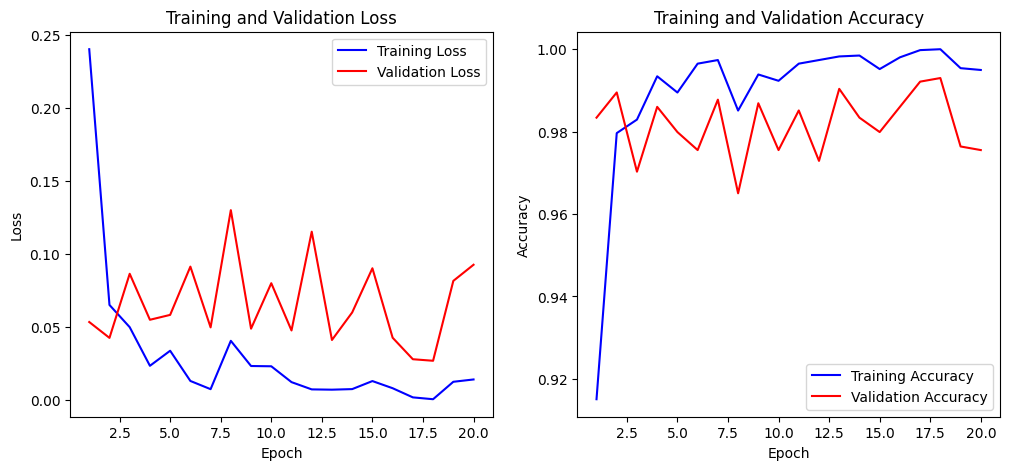

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


resnet152 = models.resnet152(pretrained=True)
resnet152.fc = nn.Linear(resnet152.fc.in_features, num_classes)
resnet152 = resnet152.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=learning_rate)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    resnet152.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet152(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    resnet152.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet152(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # Store metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(resnet152.state_dict(), 'resnet152_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pynvml

def get_gpu_power_watt(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
    power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
    power_watt = power_mw / 1000.0
    pynvml.nvmlShutdown()
    return power_watt


folders = [
    "/content/dataset/pituitary",
    "/content/dataset/meningioma",
    "/content/dataset/notumor",
    "/content/dataset/glioma"
]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

model = models.resnet152(pretrained=True).cuda()
model.eval()

valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}


total_energy_joules = 0.0
total_time_seconds = 0.0

for folder in folders:
    for file_name in os.listdir(folder):
        if os.path.splitext(file_name)[1].lower() in valid_extensions:
            image_path = os.path.join(folder, file_name)
            image = Image.open(image_path).convert("RGB")
            input_tensor = preprocess(image).unsqueeze(0).cuda()

            start_time = time.time()
            power_before = get_gpu_power_watt()

            with torch.no_grad():
                output = model(input_tensor)

            power_after = get_gpu_power_watt()
            end_time = time.time()

            avg_power = (power_before + power_after) / 2
            elapsed_time = end_time - start_time

            total_energy_joules += avg_power * elapsed_time
            total_time_seconds += elapsed_time


if total_time_seconds > 0:
    avg_power_watt = total_energy_joules / total_time_seconds
    print(f"Average GPU power consumption over all inferences: {avg_power_watt:.2f} Watts")
else:
    print("No images processed.")




Average GPU power consumption over all inferences: 59.12 Watts


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights


weights = ResNet152_Weights.DEFAULT
model = resnet152(weights=weights)


num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 218MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Figshare Test Dataset(D2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9860    0.9860    0.9860       143
  meningioma     0.9605    0.9605    0.9605       152
     notumor     0.9929    0.9653    0.9789       144
      glioma     0.9744    1.0000    0.9870       152

    accuracy                         0.9780       591
   macro avg     0.9784    0.9780    0.9781       591
weighted avg     0.9781    0.9780    0.9780       591



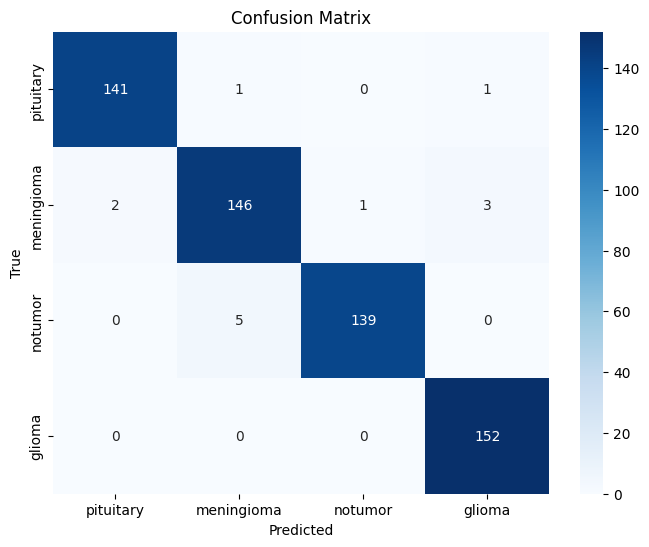

Macro-average AUC score: 0.9992
Cohen's Kappa Score: 0.9707


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['pituitary','meningioma','notumor','glioma']
num_classes = len(class_names)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ntest', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.resnet152(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model.load_state_dict(torch.load('resnet152_trained.pth', map_location=device))
model.eval()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

y_true_onehot = label_binarize(y_true, classes=range(num_classes))

auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

## Kaggle test Dataset(D3)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9894    0.9333    0.9605       300
  meningioma     0.9352    0.9902    0.9619       306
     notumor     0.9975    0.9951    0.9963       405
      glioma     0.9933    0.9933    0.9933       300

    accuracy                         0.9794      1311
   macro avg     0.9789    0.9780    0.9780      1311
weighted avg     0.9802    0.9794    0.9794      1311



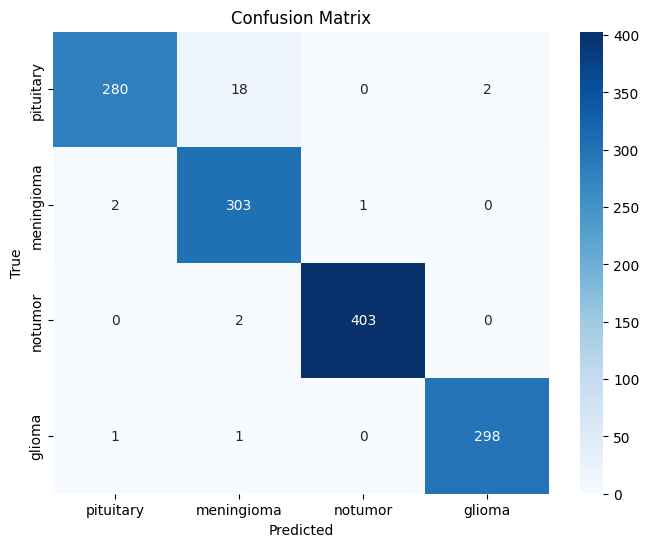

Macro-average AUC score: 0.9975
Cohen's Kappa Score: 0.9724


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['pituitary','meningioma', 'notumor',  'glioma']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/newtest/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.resnet152(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model.load_state_dict(torch.load('resnet152_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


## Other Dataset 254X254 (D4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9514    0.9660    0.9587       324
  meningioma     0.9506    0.9211    0.9356       355
     notumor     0.9746    0.9575    0.9660       400
   pituitary     0.9643    1.0000    0.9818       351

    accuracy                         0.9608      1430
   macro avg     0.9602    0.9612    0.9605      1430
weighted avg     0.9608    0.9608    0.9607      1430



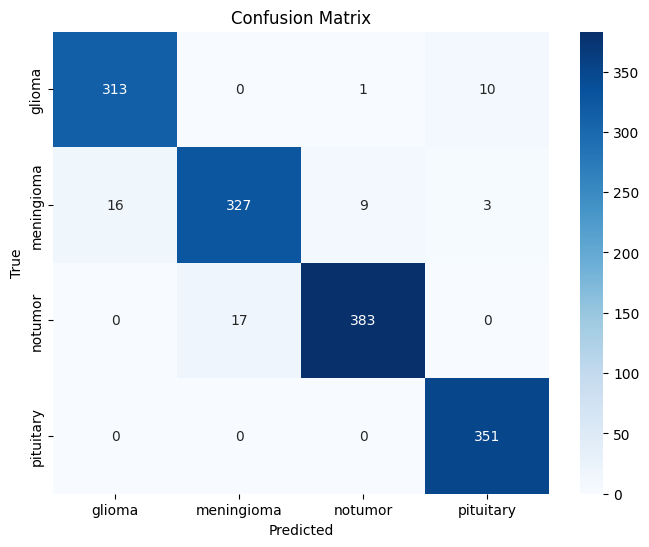

Macro-average AUC score: 0.9962
Cohen's Kappa Score: 0.9477


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/testcase/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.resnet152(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


model.load_state_dict(torch.load('resnet152_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


# EfficientNetV2

In [ ]:
import torch
import torch.nn as nn
import timm


num_classes = 4


model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)


if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
else:
    raise ValueError("Model classifier head not found or unexpected structure")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
outputs = model(dummy_input)
print(outputs)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

tensor([[ 0.0775, -0.0125, -0.0280,  0.0173]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Epoch [1/20], Train Loss: 0.4664, Train Acc: 0.8704, Val Loss: 0.1319, Val Acc: 0.9650
Epoch [2/20], Train Loss: 0.0998, Train Acc: 0.9704, Val Loss: 0.0615, Val Acc: 0.9747
Epoch [3/20], Train Loss: 0.0473, Train Acc: 0.9866, Val Loss: 0.0510, Val Acc: 0.9816
Epoch [4/20], Train Loss: 0.0245, Train Acc: 0.9934, Val Loss: 0.0375, Val Acc: 0.9860
Epoch [5/20], Train Loss: 0.0122, Train Acc: 0.9974, Val Loss: 0.0419, Val Acc: 0.9816
Epoch [6/20], Train Loss: 0.0162, Train Acc: 0.9947, Val Loss: 0.0532, Val Acc: 0.9860
Epoch [7/20], Train Loss: 0.0117, Train Acc: 0.9967, Val Loss: 0.0343, Val Acc: 0.9860
Epoch [8/20], Train Loss: 0.0071, Train Acc: 0.9982, Val Loss: 0.0236, Val Acc: 0.9913
Epoch [9/20], Train Loss: 0.0025, Train Acc: 0.9998, Val Loss: 0.0272, Val Acc: 0.9921
Epoch [10/20], Train Loss: 0.0074, Train Acc: 0.9987, Val Loss: 0.0453, Val Acc: 0.9843
Epoch [11/20], Train Loss: 0.0081, Train Acc: 0.9967, Val Loss: 0.0450, Val Acc: 0.9843
Epoch [12/20], Train Loss: 0.0111, Train 

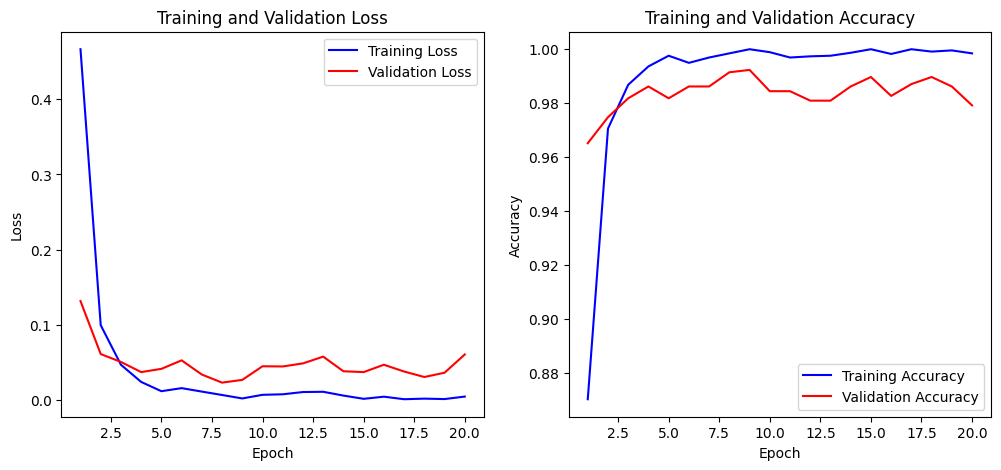

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


model = timm.create_model('tf_efficientnetv2_b0', pretrained=True)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(model.state_dict(), 'efficientnetv2_b0_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import os
from PIL import Image
import torch
import timm
import torchvision.transforms as transforms
import time
import pynvml

def get_gpu_power_watt(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
    power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
    power_watt = power_mw / 1000.0
    pynvml.nvmlShutdown()
    return power_watt


folders = [
    "/content/dataset/pituitary",
    "/content/dataset/meningioma",
    "/content/dataset/notumor",
    "/content/dataset/glioma"
]


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = timm.create_model("tf_efficientnetv2_b0", pretrained=True)
model.eval()
model.to(device)

valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

total_energy_joules = 0.0
total_time_seconds = 0.0

for folder in folders:
    for file_name in os.listdir(folder):
        ext = os.path.splitext(file_name)[1].lower()
        if ext in valid_extensions:
            image_path = os.path.join(folder, file_name)
            img = Image.open(image_path).convert("RGB")
            input_tensor = preprocess(img).unsqueeze(0).to(device)

            start_time = time.time()
            power_before = get_gpu_power_watt()

            with torch.no_grad():
                outputs = model(input_tensor)

            power_after = get_gpu_power_watt()
            end_time = time.time()

            avg_power = (power_before + power_after) / 2
            elapsed_time = end_time - start_time

            total_energy_joules += avg_power * elapsed_time
            total_time_seconds += elapsed_time

if total_time_seconds > 0:
    avg_power_watt = total_energy_joules / total_time_seconds
    print(f"Average GPU power consumption over all inferences: {avg_power_watt:.2f} Watts")
    print(f"Total inference time: {total_time_seconds:.2f} seconds")
else:
    print("No images processed.")


Average GPU power consumption over all inferences: 55.59 Watts
Total inference time: 85.82 seconds


## Figshare Test Dataset (D2)

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9930    0.9930    0.9930       143
  meningioma     0.9934    0.9934    0.9934       152
     notumor     1.0000    0.9792    0.9895       144
   pituitary     0.9806    1.0000    0.9902       152

    accuracy                         0.9915       591
   macro avg     0.9918    0.9914    0.9915       591
weighted avg     0.9916    0.9915    0.9915       591



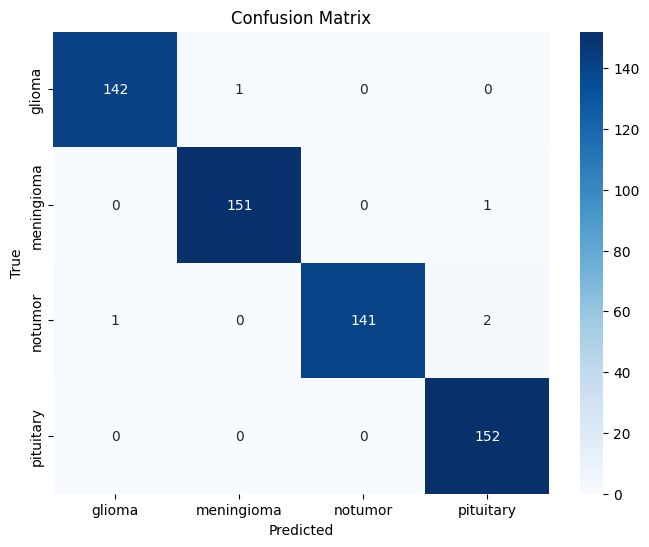

Macro-average AUC score: 1.0000
Cohen's Kappa Score: 0.9887


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ntest', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = timm.create_model('tf_efficientnetv2_b0', pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')
model = model.to(device)


model.load_state_dict(torch.load('efficientnetv2_b0_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


##Kaggle Test Dataset (D3)

Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9673    0.9867    0.9769       300
  meningioma     0.9865    0.9542    0.9701       306
     notumor     0.9975    0.9975    0.9975       405
      glioma     0.9836    0.9967    0.9901       300

    accuracy                         0.9847      1311
   macro avg     0.9837    0.9838    0.9836      1311
weighted avg     0.9848    0.9847    0.9847      1311



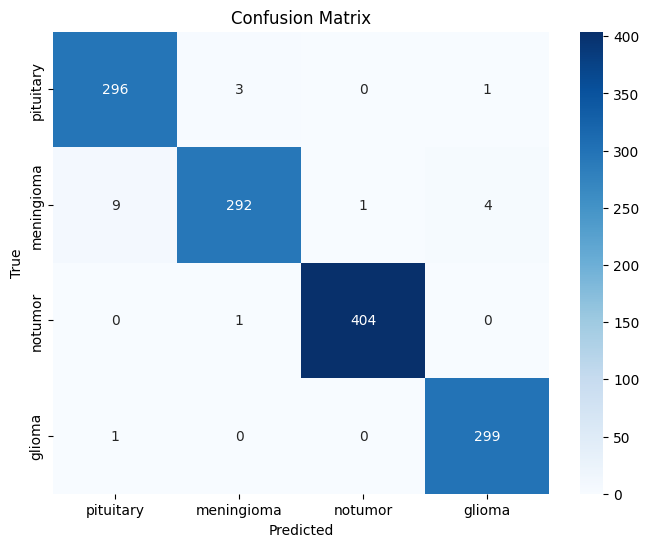

Macro-average AUC score: 0.9997
Cohen's Kappa Score: 0.9795


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['pituitary','meningioma', 'notumor',  'glioma']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/newtest/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = timm.create_model('tf_efficientnetv2_b0', pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')
model = model.to(device)


model.load_state_dict(torch.load('efficientnetv2_b0_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

## Other Dataset 254X254 (D4)

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9671    0.9969    0.9818       324
  meningioma     1.0000    0.9662    0.9828       355
     notumor     0.9950    0.9975    0.9963       400
   pituitary     0.9972    1.0000    0.9986       351

    accuracy                         0.9902      1430
   macro avg     0.9898    0.9902    0.9899      1430
weighted avg     0.9904    0.9902    0.9902      1430



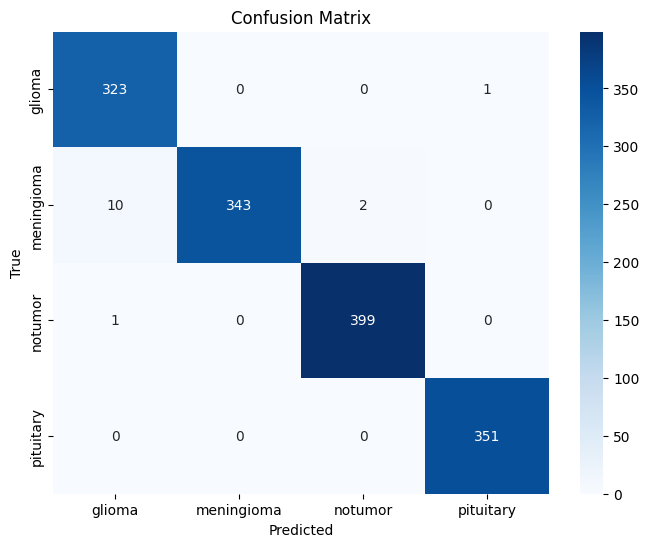

Macro-average AUC score: 0.9999
Cohen's Kappa Score: 0.9869


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/testcase/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = timm.create_model('tf_efficientnetv2_b0', pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')
model = model.to(device)


model.load_state_dict(torch.load('efficientnetv2_b0_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

# VGG19

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


num_classes = 4


model = models.vgg19(pretrained=True)


if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
else:
    raise ValueError("Unexpected classifier structure")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
outputs = model(dummy_input)
print(outputs)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 230MB/s]


tensor([[-0.5842,  0.1294, -0.7207, -0.2901]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Epoch [1/20], Train Loss: 0.4324, Train Acc: 0.8373, Val Loss: 0.3564, Val Acc: 0.8671
Epoch [2/20], Train Loss: 0.2340, Train Acc: 0.9188, Val Loss: 0.2557, Val Acc: 0.9213
Epoch [3/20], Train Loss: 0.1355, Train Acc: 0.9564, Val Loss: 0.1863, Val Acc: 0.9379
Epoch [4/20], Train Loss: 0.0702, Train Acc: 0.9753, Val Loss: 0.0908, Val Acc: 0.9694
Epoch [5/20], Train Loss: 0.0571, Train Acc: 0.9803, Val Loss: 0.1459, Val Acc: 0.9449
Epoch [6/20], Train Loss: 0.0841, Train Acc: 0.9731, Val Loss: 0.0953, Val Acc: 0.9615
Epoch [7/20], Train Loss: 0.0306, Train Acc: 0.9915, Val Loss: 0.0632, Val Acc: 0.9825
Epoch [8/20], Train Loss: 0.0338, Train Acc: 0.9897, Val Loss: 0.0532, Val Acc: 0.9878
Epoch [9/20], Train Loss: 0.0402, Train Acc: 0.9871, Val Loss: 0.1476, Val Acc: 0.9624
Epoch [10/20], Train Loss: 0.0386, Train Acc: 0.9901, Val Loss: 0.0849, Val Acc: 0.9729
Epoch [11/20], Train Loss: 0.0155, Train Acc: 0.9958, Val Loss: 0.1059, Val Acc: 0.9703
Epoch [12/20], Train Loss: 0.0144, Train 

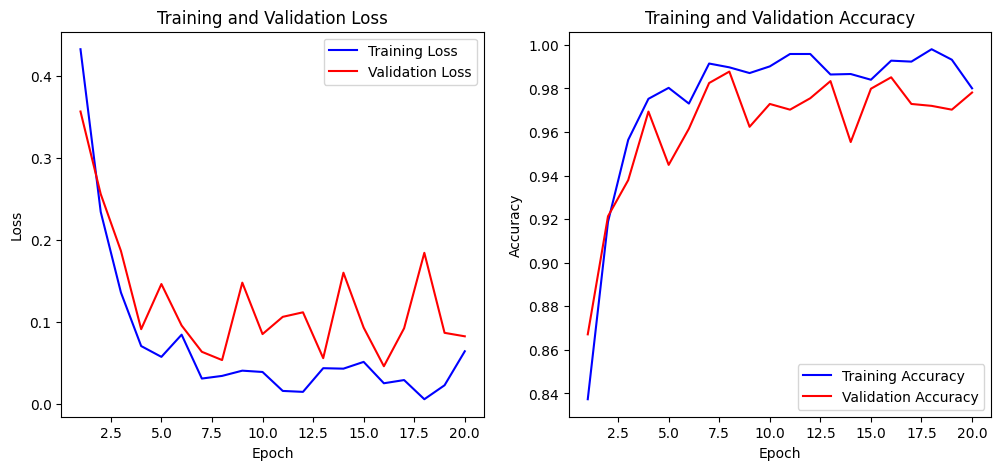

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


vgg19 = models.vgg19(pretrained=True)

vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, num_classes)
vgg19 = vgg19.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.parameters(), lr=learning_rate)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    vgg19.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    vgg19.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg19(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(vgg19.state_dict(), 'vgg19_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pynvml

def get_gpu_power_watt(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
    power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
    power_watt = power_mw / 1000.0
    pynvml.nvmlShutdown()
    return power_watt


folders = [
    "/content/dataset/pituitary",
    "/content/dataset/meningioma",
    "/content/dataset/notumor",
    "/content/dataset/glioma"
]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

model = models.vgg19(pretrained=True).cuda()
model.eval()

valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}


total_energy_joules = 0.0
total_time_seconds = 0.0

for folder in folders:
    for file_name in os.listdir(folder):
        if os.path.splitext(file_name)[1].lower() in valid_extensions:
            image_path = os.path.join(folder, file_name)
            image = Image.open(image_path).convert("RGB")
            input_tensor = preprocess(image).unsqueeze(0).cuda()

            start_time = time.time()
            power_before = get_gpu_power_watt()

            with torch.no_grad():
                output = model(input_tensor)

            power_after = get_gpu_power_watt()
            end_time = time.time()

            avg_power = (power_before + power_after) / 2
            elapsed_time = end_time - start_time

            total_energy_joules += avg_power * elapsed_time
            total_time_seconds += elapsed_time


if total_time_seconds > 0:
    avg_power_watt = total_energy_joules / total_time_seconds
    print(f"Average GPU power consumption over all inferences: {avg_power_watt:.2f} Watts")
else:
    print("No images processed.")

Average GPU power consumption over all inferences: 72.31 Watts


## Figshare Test Dataset(D2)

Classification Report:

              precision    recall  f1-score   support

      glioma     0.9851    0.9231    0.9531       143
  meningioma     0.9255    0.9803    0.9521       152
     notumor     1.0000    0.9514    0.9751       144
   pituitary     0.9560    1.0000    0.9775       152

    accuracy                         0.9645       591
   macro avg     0.9666    0.9637    0.9644       591
weighted avg     0.9659    0.9645    0.9645       591



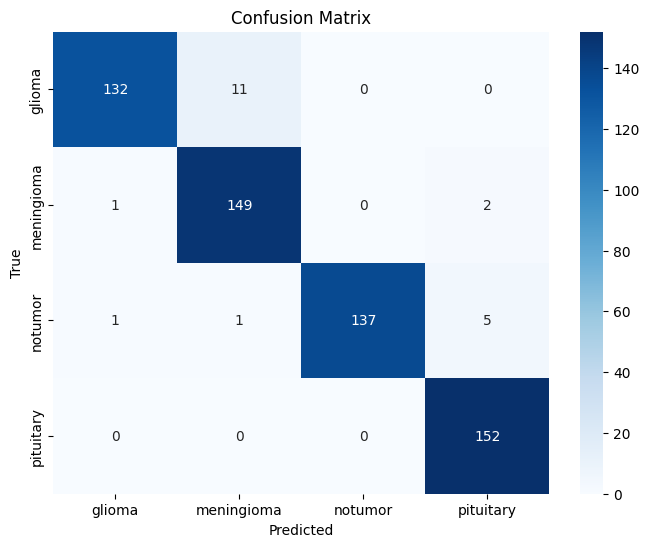

Macro-average AUC score: 0.9983
Cohen's Kappa Score: 0.9526


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ntest', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.vgg19(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('vgg19_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


## Kaggle Test Dataset(D3)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9895    0.9400    0.9641       300
  meningioma     0.9344    0.9771    0.9553       306
     notumor     1.0000    0.9877    0.9938       405
      glioma     0.9804    1.0000    0.9901       300

    accuracy                         0.9771      1311
   macro avg     0.9761    0.9762    0.9758      1311
weighted avg     0.9778    0.9771    0.9772      1311



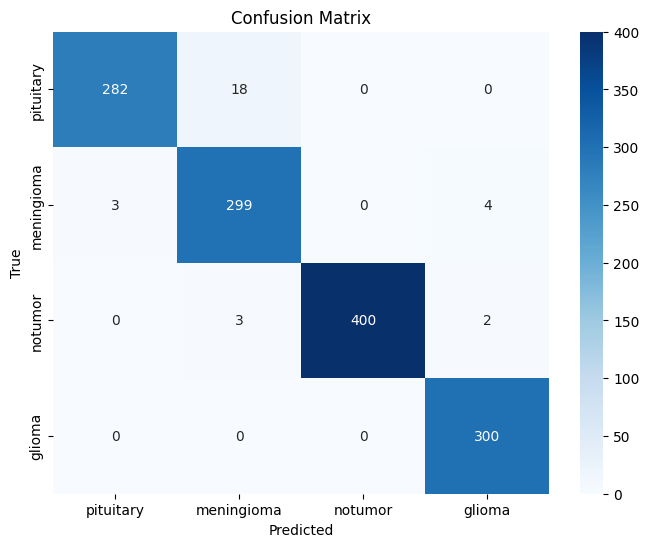

Macro-average AUC score: 0.9980
Cohen's Kappa Score: 0.9693


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['pituitary','meningioma', 'notumor',  'glioma']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/newtest/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.vgg19(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('vgg19_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


## Other Dataset 254X254 (D4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9968    0.9691    0.9828       324
  meningioma     0.9724    0.9915    0.9819       355
     notumor     1.0000    0.9950    0.9975       400
   pituitary     0.9887    1.0000    0.9943       351

    accuracy                         0.9895      1430
   macro avg     0.9895    0.9889    0.9891      1430
weighted avg     0.9897    0.9895    0.9895      1430



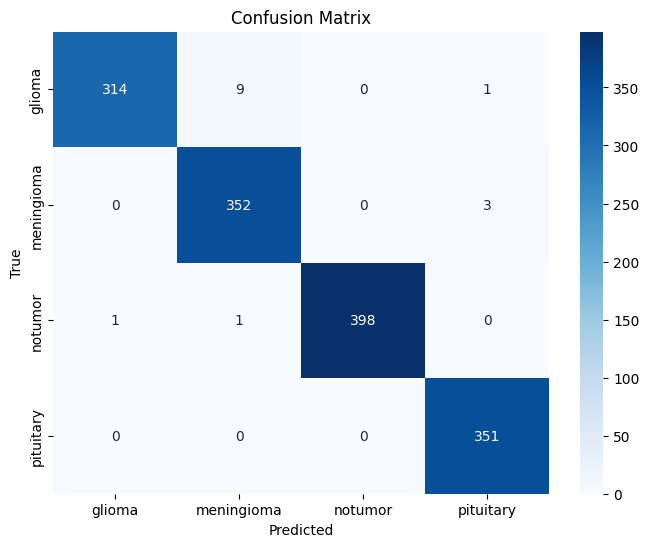

Macro-average AUC score: 0.9996
Cohen's Kappa Score: 0.9860


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/testcase/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.vgg19(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('vgg19_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


# ConvNext Base

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import convnext_base


num_classes = 4


model = convnext_base(pretrained=True)


model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
outputs = model(dummy_input)
print(outputs)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:01<00:00, 197MB/s]


tensor([[-0.2895,  0.3799, -0.3236, -0.2638]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Epoch [1/20], Train Loss: 0.2721, Train Acc: 0.9074, Val Loss: 0.0602, Val Acc: 0.9799
Epoch [2/20], Train Loss: 0.0444, Train Acc: 0.9840, Val Loss: 0.0362, Val Acc: 0.9851
Epoch [3/20], Train Loss: 0.0227, Train Acc: 0.9928, Val Loss: 0.0150, Val Acc: 0.9965
Epoch [4/20], Train Loss: 0.0067, Train Acc: 0.9980, Val Loss: 0.0125, Val Acc: 0.9974
Epoch [5/20], Train Loss: 0.0052, Train Acc: 0.9991, Val Loss: 0.0244, Val Acc: 0.9930
Epoch [6/20], Train Loss: 0.0244, Train Acc: 0.9934, Val Loss: 0.0835, Val Acc: 0.9712
Epoch [7/20], Train Loss: 0.0147, Train Acc: 0.9954, Val Loss: 0.0499, Val Acc: 0.9851
Epoch [8/20], Train Loss: 0.0150, Train Acc: 0.9963, Val Loss: 0.0469, Val Acc: 0.9878
Epoch [9/20], Train Loss: 0.0098, Train Acc: 0.9965, Val Loss: 0.0636, Val Acc: 0.9799
Epoch [10/20], Train Loss: 0.0291, Train Acc: 0.9912, Val Loss: 0.0315, Val Acc: 0.9904
Epoch [11/20], Train Loss: 0.0049, Train Acc: 0.9989, Val Loss: 0.0190, Val Acc: 0.9948
Epoch [12/20], Train Loss: 0.0009, Train 

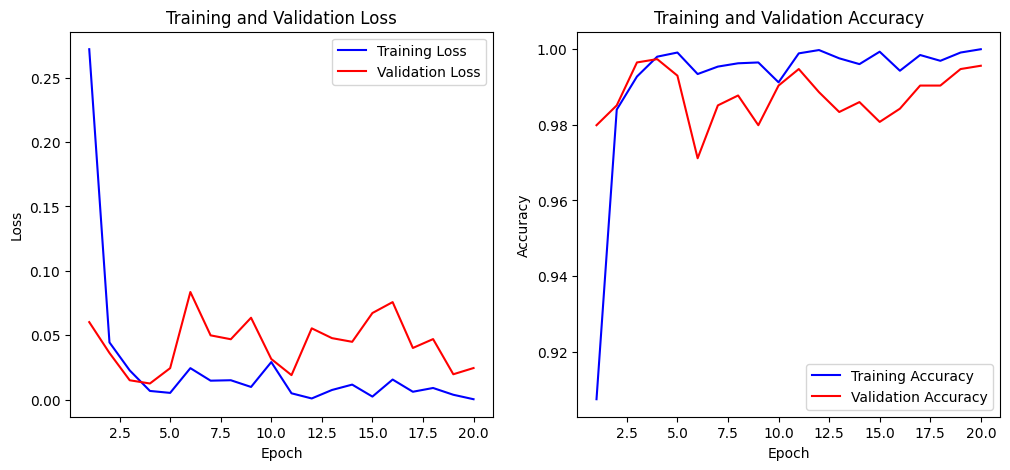

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


convnext_base = models.convnext_base(pretrained=True)

convnext_base.classifier[2] = nn.Linear(convnext_base.classifier[2].in_features, num_classes)
convnext_base = convnext_base.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_base.parameters(), lr=learning_rate)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    convnext_base.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = convnext_base(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    convnext_base.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = convnext_base(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(convnext_base.state_dict(), 'convnext_base_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch [1/20], Train Loss: 0.2809, Train Acc: 0.9015, Val Loss: 0.0626, Val Acc: 0.9816
Epoch [2/20], Train Loss: 0.0450, Train Acc: 0.9853, Val Loss: 0.0472, Val Acc: 0.9869
Epoch [3/20], Train Loss: 0.0149, Train Acc: 0.9961, Val Loss: 0.0289, Val Acc: 0.9904
Epoch [4/20], Train Loss: 0.0196, Train Acc: 0.9934, Val Loss: 0.1003, Val Acc: 0.9764
Epoch [5/20], Train Loss: 0.0274, Train Acc: 0.9904, Val Loss: 0.0348, Val Acc: 0.9904
Epoch [6/20], Train Loss: 0.0174, Train Acc: 0.9945, Val Loss: 0.0414, Val Acc: 0.9921
Epoch [7/20], Train Loss: 0.0152, Train Acc: 0.9941, Val Loss: 0.0463, Val Acc: 0.9869
Epoch [8/20], Train Loss: 0.0019, Train Acc: 0.9993, Val Loss: 0.0468, Val Acc: 0.9878
Epoch [9/20], Train Loss: 0.0031, Train Acc: 0.9991, Val Loss: 0.0498, Val Acc: 0.9860
Epoch [10/20], Train Loss: 0.0110, Train Acc: 0.9976, Val Loss: 0.0511, Val Acc: 0.9851
Epoch [11/20], Train Loss: 0.0038, Train Acc: 0.9991, Val Loss: 0.0374, Val Acc: 0.9913
Epoch [12/20], Train Loss: 0.0011, Train 

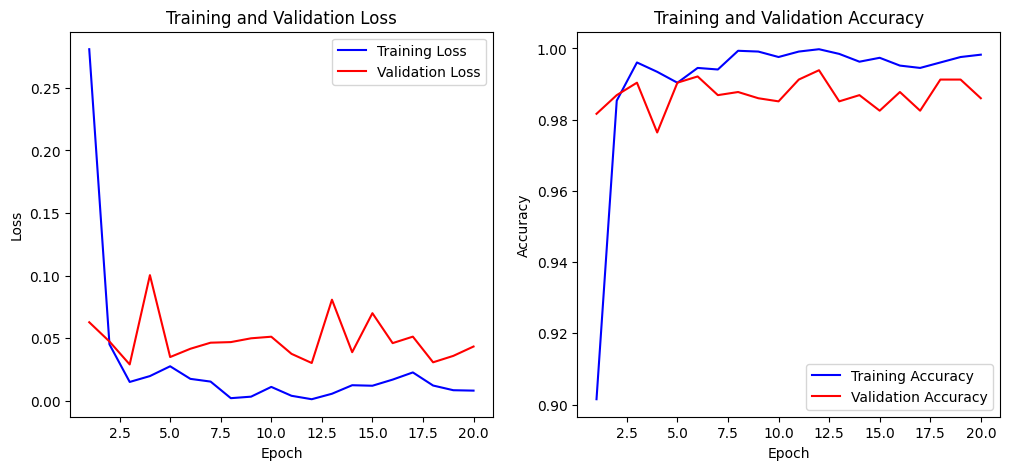

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

convnext_base = models.convnext_base(pretrained=True)
convnext_base.classifier[2] = nn.Linear(convnext_base.classifier[2].in_features, num_classes)
convnext_base = convnext_base.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_base.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    convnext_base.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = convnext_base(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    convnext_base.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = convnext_base(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # Store metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(convnext_base.state_dict(), 'convnext_base_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pynvml

def get_gpu_power_watt(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
    power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
    power_watt = power_mw / 1000.0
    pynvml.nvmlShutdown()
    return power_watt


folders = [
    "/content/dataset/pituitary",
    "/content/dataset/meningioma",
    "/content/dataset/notumor",
    "/content/dataset/glioma"
]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

model = models.resnet152(pretrained=True).cuda()
model.eval()

valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}


total_energy_joules = 0.0
total_time_seconds = 0.0

for folder in folders:
    for file_name in os.listdir(folder):
        if os.path.splitext(file_name)[1].lower() in valid_extensions:
            image_path = os.path.join(folder, file_name)
            image = Image.open(image_path).convert("RGB")
            input_tensor = preprocess(image).unsqueeze(0).cuda()

            start_time = time.time()
            power_before = get_gpu_power_watt()

            with torch.no_grad():
                output = model(input_tensor)

            power_after = get_gpu_power_watt()
            end_time = time.time()

            avg_power = (power_before + power_after) / 2
            elapsed_time = end_time - start_time

            total_energy_joules += avg_power * elapsed_time
            total_time_seconds += elapsed_time


if total_time_seconds > 0:
    avg_power_watt = total_energy_joules / total_time_seconds
    print(f"Average GPU power consumption over all inferences: {avg_power_watt:.2f} Watts")
else:
    print("No images processed.")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU power consumption over all inferences: 59.13 Watts


## Figshare Test Dataset (D2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor     1.0000    1.0000    1.0000       143
meningioma_tumor     1.0000    0.9934    0.9967       152
        no_tumor     1.0000    1.0000    1.0000       144
 pituitary_tumor     0.9935    1.0000    0.9967       152

        accuracy                         0.9983       591
       macro avg     0.9984    0.9984    0.9984       591
    weighted avg     0.9983    0.9983    0.9983       591



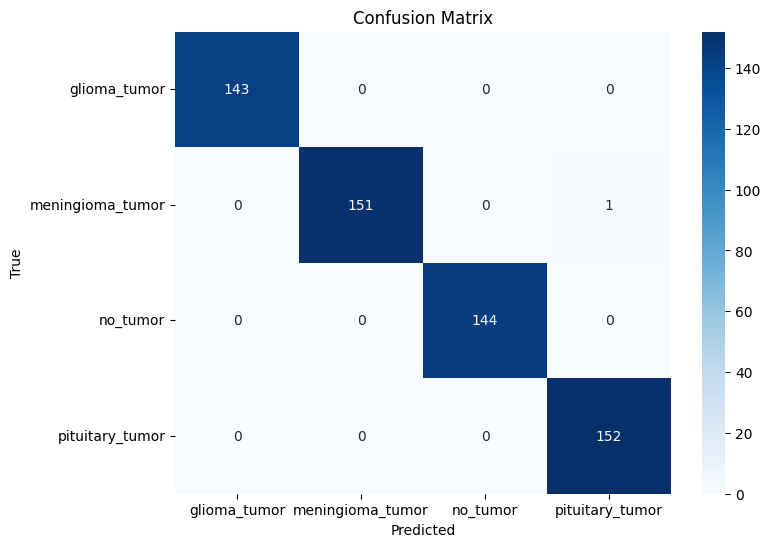

Macro-average AUC score: 1.0000
Cohen's Kappa Score: 0.9977


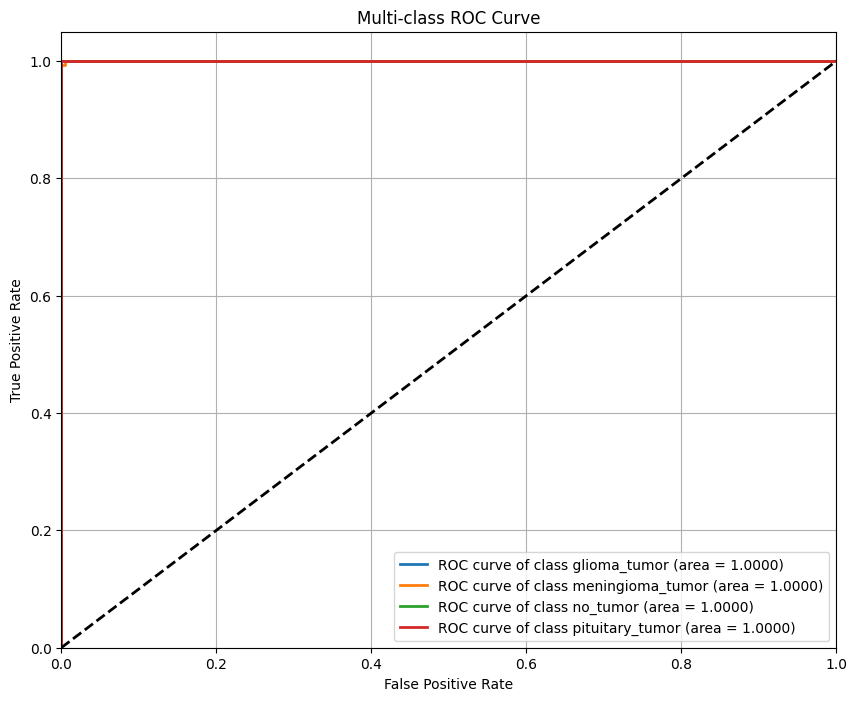

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ntest', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.convnext_base(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('convnext_base_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(10, 8))


for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.4f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



## Kaggle Test Dataset (D3)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9967    0.9967    0.9967       300
  meningioma     0.9935    0.9935    0.9935       306
     notumor     1.0000    0.9975    0.9988       405
      glioma     0.9967    1.0000    0.9983       300

    accuracy                         0.9969      1311
   macro avg     0.9967    0.9969    0.9968      1311
weighted avg     0.9970    0.9969    0.9969      1311



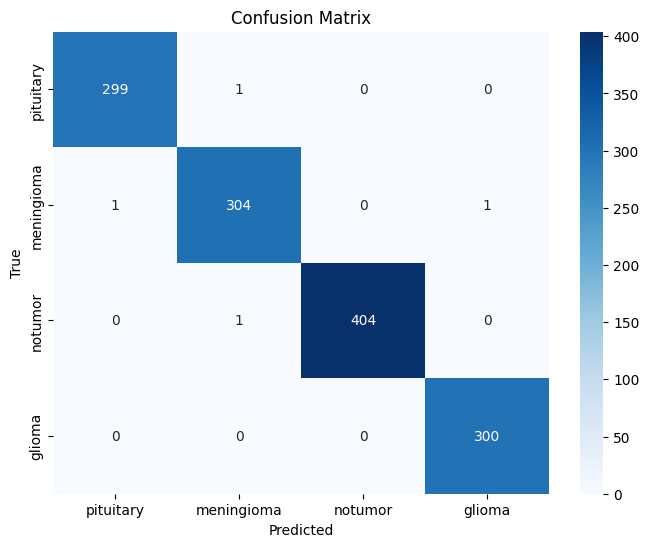

Macro-average AUC score: 0.9998
Cohen's Kappa Score: 0.9959


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['pituitary','meningioma', 'notumor',  'glioma']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/newtest/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.convnext_base(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('convnext_base_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


## Other Dataset 254X254 (D4)

Classification Report:

              precision    recall  f1-score   support

      glioma     1.0000    0.9969    0.9985       324
  meningioma     0.9972    1.0000    0.9986       355
     notumor     0.9975    0.9975    0.9975       400
   pituitary     1.0000    1.0000    1.0000       351

    accuracy                         0.9986      1430
   macro avg     0.9987    0.9986    0.9986      1430
weighted avg     0.9986    0.9986    0.9986      1430



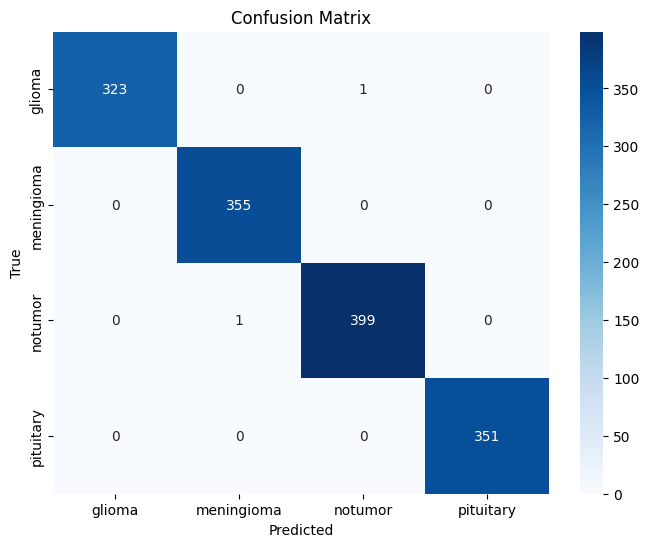

Macro-average AUC score: 1.0000
Cohen's Kappa Score: 0.9981


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/testcase/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.convnext_base(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('convnext_base_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")